# SVM
##### Sean Wade

In [1]:
from __future__ import division, print_function
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
from tabulate import tabulate
import time

from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

ImportError: No module named tabulate

## The Data

The goal of this dataset is predicting if breast cancer is malignant or benign.

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - class:
                - WDBC-Malignant
                - WDBC-Benign

In [2]:
breast_cancer = load_breast_cancer()

In [3]:
data, labels = breast_cancer['data'], breast_cancer['target']
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)

## Vanilla Model

In [4]:
model = svm.SVC()
model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [5]:
y_hat = model.predict(x_test)
accuracy_score(y_test, y_hat)

0.59064327485380119

## Adjusting Hyperparameters

In [6]:
def gridSearch(cv_params, fixed_params={}):
    normalized_data = preprocessing.scale(data)
    gs = GridSearchCV(svm.SVC(**fixed_params), cv_params) 
    return gs.fit(normalized_data, labels)

In [7]:
def gridResults(gs):
    sort_idx = np.argsort(gs.cv_results_['mean_test_score'])[::-1]
    params = np.array(gs.cv_results_["params"])[sort_idx]
    train_time = gs.cv_results_["mean_fit_time"][sort_idx]
    acc = gs.cv_results_["mean_test_score"][sort_idx]
    table = []
    for i in range(len(params)):
         table.append(['%.6f' % acc[i], '%.4f' % train_time[i], params[i]])
    print(tabulate(table, headers=['Accuracy', 'Time', 'Parameters']))

In [8]:
cv_params = {
    'kernel': ['poly'],
    'degree': [2,3,4,5,6],
    'coef0': [10**i for i in range(0,6)]}
gs = gridSearch(cv_params)
gridResults(gs)

NameError: global name 'preprocessing' is not defined

In [9]:
cv_params = {'kernel': ['linear', 'rbf', 'poly'],
             'gamma': [10**i for i in range(-5,6)],
             'C': [10**i for i in range(-5,6)]}
gs = gridSearch(cv_params)
gridResults(gs)

  Accuracy    Time  Parameters
----------  ------  --------------------------------------------------
  0.957821  4.5313  {'kernel': 'linear', 'C': 100, 'gamma': 0.001}
  0.957821  4.465   {'kernel': 'linear', 'C': 100, 'gamma': 10}
  0.957821  4.5129  {'kernel': 'linear', 'C': 100, 'gamma': 1e-05}
  0.957821  4.5454  {'kernel': 'linear', 'C': 100, 'gamma': 0.01}
  0.957821  4.5003  {'kernel': 'linear', 'C': 100, 'gamma': 0.1}
  0.957821  4.5049  {'kernel': 'linear', 'C': 100, 'gamma': 1}
  0.957821  4.4932  {'kernel': 'linear', 'C': 100, 'gamma': 0.0001}
  0.957821  4.5153  {'kernel': 'linear', 'C': 100, 'gamma': 100}
  0.957821  5.0057  {'kernel': 'linear', 'C': 100, 'gamma': 1000}
  0.957821  4.7326  {'kernel': 'linear', 'C': 100, 'gamma': 10000}
  0.957821  4.7172  {'kernel': 'linear', 'C': 100, 'gamma': 100000}
  0.954306  4.1369  {'kernel': 'linear', 'C': 10, 'gamma': 1e-05}
  0.954306  4.2653  {'kernel': 'linear', 'C': 10, 'gamma': 0.0001}
  0.954306  4.0539  {'kernel': 'linear'

### Analysis

The linear kernal is definatly the best, however the RBF can be tuned to get close to the same accuracy.  Gamma was not importantant, for C it was good to have it around 100.

## Comparison

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [24]:
def testModel(model, data, labels, num_tests=3):
    ''' Tests a model for comparison by averaging results.
    Args:
      model: sklearn model
      data : dataset
      lables : lables
      num_tests : number of times to average
    
    Returns:
      avg_score : the average model score
      avg_time : the average training time
    '''
    
    scores = []
    train_times = []
    for _ in range(num_tests):
        x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)
        start = time.time()
        model.fit(x_train, y_train)
        stop = time.time()
        train_times.append(stop - start)
        scores.append(model.score(x_test, y_test))
        
    return np.mean(scores), np.mean(train_times)


model_list = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    xgb.XGBClassifier(),
    MLPClassifier(hidden_layer_sizes=(500,)),
    svm.LinearSVC()
]

model_names = [
    'Logistic Regression',
    'KNN',
    'Descision Tree',
    'Random Forrests',
    'Gradient Boosting',
    'XGBoost',
    'MLP',
    'SVM'
]

score_list = []
time_list = []

for model in model_list:
    score, train_time = testModel(model, data, labels)
    score_list.append(score)
    time_list.append(train_time)
    
print(tabulate([[x,y,z] for x,y,z in zip(model_names, score_list, time_list)],
               headers=['Model', 'Accuracy', 'Time']))

Model                  Accuracy        Time
-------------------  ----------  ----------
Logistic Regression    0.931774  0.00544039
KNN                    0.949318  0.00049003
Descision Tree         0.910331  0.00455562
Random Forrests        0.964912  0.0313366
Gradient Boosting      0.937622  0.135269
XGBoost                0.957115  0.0781283
MLP                    0.898635  0.176375
SVM                    0.896686  0.0184272


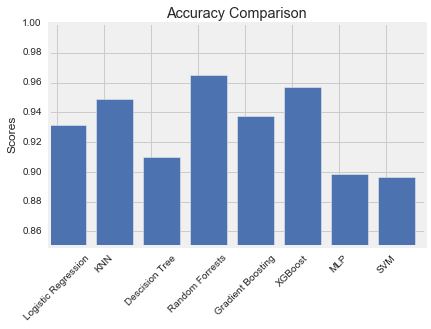

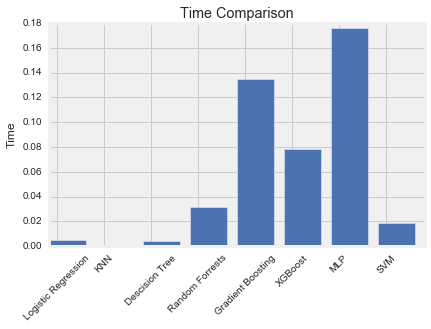

In [25]:
# Plot Results
f, ax = plt.subplots()
ind = np.arange(len(score_list))
bar_1 = ax.bar(ind, score_list)
ax.set_ylabel('Scores')
ax.set_title('Accuracy Comparison')
ax.set_xticks(ind + .35 / 2)
ax.set_xticklabels(model_names, rotation=45)
plt.ylim(.85,1)
plt.show()

f, ax = plt.subplots()
ind = np.arange(len(time_list))
bar_1 = ax.bar(ind, time_list)
ax.set_ylabel('Time')
ax.set_title('Time Comparison')
ax.set_xticks(ind + .35 / 2)
ax.set_xticklabels(model_names, rotation=45)
plt.show()

### Results

The SVM classifier is very comparible to the other methods.  It is prety fast to train and can be tunned to get better resutls.

## Extra Credit

In [17]:
scores = []
for _ in range(10):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)
    
    params = {
        'kernel': 'linear', 
        'C': 100, 
        'gamma': 0.001 }
    
    model = svm.SVC(**params)
    model.fit(x_train, y_train)
    scores.append(model.score(x_test, y_test))
    
print("Accuracy: %.3f" % np.mean(scores))

Accuracy: 0.962


Plus I found why poly wasn't working so Dr. J said I could get some extra points.